In [1]:
import ast
from pathlib import Path

import geopandas as gpd
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.geometry import Point
from osmnx.distance import great_circle_vec

In [2]:
pd.set_option("display.max_columns", None)
UBASEPATH = Path('/iarai/public/t4c/uber')


CITY = "barcelona"

UFILE = 'movement-speeds-hourly-barcelona-2020-2.parquet'
OBASEPATH = Path('/iarai/public/t4c/osm')
place = "spain-200101-truncated"

ONODESFILE = "%s_nodes.parquet" % place
OWAYSFILE = "%s_ways.parquet" % place

uspeeds_df = pd.read_parquet(UBASEPATH / UFILE)
uspeeds_df["osm_way_id"] = uspeeds_df["osm_way_id"].astype(str)
print(uspeeds_df.columns)


uspeeds_df

Index(['year', 'month', 'day', 'hour', 'utc_timestamp', 'segment_id',
       'start_junction_id', 'end_junction_id', 'osm_way_id',
       'osm_start_node_id', 'osm_end_node_id', 'speed_kph_mean',
       'speed_kph_stddev'],
      dtype='object')


,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev
0,2020,2,18,21,2020-02-18T20:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,42.992,15.530
1,2020,2,11,20,2020-02-11T19:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,43.418,17.464
2,2020,2,16,15,2020-02-16T14:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,45.918,19.958
3,2020,2,16,22,2020-02-16T21:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,40.526,24.419
4,2020,2,20,21,2020-02-20T20:00:00.000Z,2c72d02f0a169894a1ab1c518761cc8ed782671e,cff3a52a4c4b3b4051e51519d8a9724c8823aa33,1bf52f16a370a1b42048ffa6d7db90c6df416190,237659851,30238017,30246860,30.575,13.414
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74268,2020,2,16,16,2020-02-16T15:00:00.000Z,8c48ec71ed1df701458ad59510e198bc7233825b,9baf980625f0f0ebc8843f5320367db9a8cb8b1a,be68c37f4d777f9d7fb81d84a519ead45783a795,546607926,3134509191,797407467,29.769,15.495
74269,2020,2,11,21,2020-02-11T20:00:00.000Z,8c48ec71ed1df701458ad59510e198bc7233825b,9baf980625f0f0ebc8843f5320367db9a8cb8b1a,be68c37f4d777f9d7fb81d84a519ead45783a795,546607926,3134509191,797407467,20.946,5.343
74270,2020,2,21,21,2020-02-21T20:00:00.000Z,8c48ec71ed1df701458ad59510e198bc7233825b,9baf980625f0f0ebc8843f5320367db9a8cb8b1a,be68c37f4d777f9d7fb81d84a519ead45783a795,546607926,3134509191,797407467,29.160,5.030
74271,2020,2,4,21,2020-02-04T20:00:00.000Z,60e2cd8549b53a80e03e08ba30bb884afb72891d,864b9b2a76f790661736a07753e07eb97ffd1c8b,ddc8760fdddd4f0e3f6102c212ec012f3c358823,127005742,307752466,307752470,34.715,6.384


In [3]:
#df_nodes_osm = pd.read_parquet(OBASEPATH / ONODESFILE)
df_nodes_osm = gpd.read_parquet(OBASEPATH / ONODESFILE)
print(df_nodes_osm.columns)
# print(df_nodes_osm.dtypes)
# print(df_nodes_osm)

Index(['osmid', 'y', 'x', 'version', 'timestamp', 'changeset', 'geometry'], dtype='object')


In [4]:
#df_ways_osm = pd.read_parquet(OBASEPATH / OWAYSFILE)
df_ways_osm = gpd.read_parquet(OBASEPATH / OWAYSFILE)
df_ways_osm["osmid"] = df_ways_osm["osmid"].astype(str)
df_ways_osm["refs"] = [ast.literal_eval(refs) if refs is not None and refs.startswith("[") else refs for refs in df_ways_osm["refs"]]
print(df_ways_osm.columns)

Index(['osmid', 'version', 'timestamp', 'changeset', 'highway', 'maxspeed',
       'name', 'refs', 'full_geometry', 'valid_geometry', 'geometry'],
      dtype='object')


In [5]:
assert type(df_ways_osm) == gpd.geodataframe.GeoDataFrame

In [6]:
assert uspeeds_df.groupby(
        ["osm_start_node_id", "osm_end_node_id", "osm_way_id", "year", "month", "day", "hour"]).count()[
        'speed_kph_mean'].max() == 1

In [7]:
uedges_df = uspeeds_df.groupby(["osm_start_node_id", "osm_end_node_id", "osm_way_id"]).first().reset_index()
uedges_df = uedges_df.drop(['year', 'month', 'day', 'hour', 'speed_kph_mean', 'speed_kph_stddev'], axis=1)
#print(uedges_df.columns)

uedges_df = df_ways_osm.merge(uedges_df,how='right', right_on="osm_way_id", left_on="osmid", suffixes=("_way", ""))\
    .merge(df_nodes_osm.add_suffix("_start_node"), how='left', left_on="osm_start_node_id", right_on="osmid_start_node")\
    .merge(df_nodes_osm.add_suffix("_end_node"), how='left', left_on="osm_end_node_id", right_on="osmid_end_node")
uedges_df

,osmid,version,timestamp,changeset,highway,maxspeed,name,refs,full_geometry,valid_geometry,geometry,osm_start_node_id,osm_end_node_id,osm_way_id,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_start_node,y_start_node,x_start_node,version_start_node,timestamp_start_node,changeset_start_node,geometry_start_node,osmid_end_node,y_end_node,x_end_node,version_end_node,timestamp_end_node,changeset_end_node,geometry_end_node
0,291731095,7,2019-11-27T07:51:27Z,0,residential,50,Passeig de Joan de Borbó,"[21638861, 826085074, 21638860, 6831706254, 21...",True,True,"LINESTRING (2.18804 41.37801, 2.18821 41.37757...",21638861,21638859,291731095,2020-02-14T12:00:00.000Z,94821b361d9a0a49dfc0a219ac4152093bc80d32,f26d73991b19b4cccbc026fb796a5934bd85d51c,2b0fbcf9d00f3ae1003355815a6a6c7013e5253a,2.163886e+07,41.378011,2.188040,5,2015-07-10T08:32:50Z,0,POINT (2.18804 41.37801),2.163886e+07,41.376347,2.188693,5,2015-07-10T08:32:49Z,0,POINT (2.18869 41.37635)
1,291731094,7,2018-11-02T07:42:49Z,0,tertiary,50,Passeig de Joan de Borbó,"[21638874, 3749428001, 21638873, 3749427999, 2...",True,True,"LINESTRING (2.18712 41.38037, 2.18715 41.38029...",21638872,4229056910,291731094,2020-02-14T12:00:00.000Z,29b71bc92a0bd453e08ada00684c8bfac5688729,8f19089c97eb78664d2e17cdf60004b80155f410,0f88ef4bf54f2a4006a53450d9451bc5c1fdea00,2.163887e+07,41.378797,2.187738,4,2015-07-10T08:32:50Z,0,POINT (2.18774 41.37880),4.229057e+09,41.378093,2.188009,1,2016-06-06T21:33:41Z,0,POINT (2.18801 41.37809)
2,291731094,7,2018-11-02T07:42:49Z,0,tertiary,50,Passeig de Joan de Borbó,"[21638874, 3749428001, 21638873, 3749427999, 2...",True,True,"LINESTRING (2.18712 41.38037, 2.18715 41.38029...",21638874,21638872,291731094,2020-02-14T12:00:00.000Z,0faab0b1e121c7c0011c61e4d41b0a59a6c6296e,08a1c43d2fa56cc4a37112215e2f6f24560c3e06,8f19089c97eb78664d2e17cdf60004b80155f410,2.163887e+07,41.380371,2.187119,5,2015-07-10T08:32:50Z,0,POINT (2.18712 41.38037),2.163887e+07,41.378797,2.187738,4,2015-07-10T08:32:50Z,0,POINT (2.18774 41.37880)
3,237790232,6,2017-08-01T09:57:15Z,0,tertiary,50,Passeig de Joan de Borbó,"[533662733, 5006930486, 21638886, 21638885, 29...",True,True,"LINESTRING (2.18533 41.38158, 2.18557 41.38147...",21638886,2952200683,237790232,2020-02-21T13:00:00.000Z,1e3e109e19426a9ce04fda7e0085d859e23d7703,a08e41a698264f039ff6373b70e6f6a8718645fd,c8cecccde8e8c7cf0a8e7bb299b6e499bcc4e1eb,2.163889e+07,41.381278,2.185963,2,2011-08-16T20:30:37Z,0,POINT (2.18596 41.38128),2.952201e+09,41.380957,2.186608,1,2014-07-07T09:58:42Z,0,POINT (2.18661 41.38096)
4,18512190,21,2017-09-10T10:40:27Z,0,tertiary,50,Passeig d'Isabel II,"[21638891, 533663041, 4900653316, 209105699, 4...",True,True,"LINESTRING (2.18319 41.38260, 2.18313 41.38252...",21638891,533663031,18512190,2020-02-05T21:00:00.000Z,153f6f8c7fdf0287a0aae18c8fc7d8b23d1b3d8b,c173bac23745c0e5684499e0b5a51e6f984897e5,1b105ab1371abc83f6cf9a591b08bf05a365b7c1,2.163889e+07,41.382603,2.183192,12,2011-08-16T16:18:30Z,0,POINT (2.18319 41.38260),5.336630e+08,41.381379,2.182166,4,2017-10-18T02:36:31Z,0,POINT (2.18217 41.38138)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6061,36005986,13,2019-06-23T16:33:37Z,0,tertiary,50,Carrer Pla de Matabous,"[420876545, 420876546, 420876547, 6485217427, ...",True,True,"LINESTRING (2.18541 41.49896, 2.18561 41.49953...",6485217427,425763064,36005986,2020-02-09T19:00:00.000Z,56f997099343b00a6cefe29e7c873d9b11b6df47,35b453988332b37c112424d1253a391beb377d71,b6156e524f084d8b7f3f9678824d3cc9e6f4b9d4,6.485217e+09,41.500209,2.185904,1,2019-05-20T08:32:59Z,0,POINT (2.18590 41.50021),4.257631e+08,41.500466,2.186021,4,2012-08-05T18:09:26Z,0,POINT (2.18602 41.50047)
6062,37286986,17,2019-09-22T19:46:16Z,0,tertiary,50,pont del Molinet,"[6816047955, 6486942738, 434451648, 434451647,...",True,True,"LINESTRING (2.20795 41.43448, 2.20816 41.43474...",6486942738,434451638,37286986,2020-02-20T12:00:00.000Z,a8493278306073863a

In [8]:
uedges_df["length_meters"] = [great_circle_vec(x_u,y_u,x_v,y_v)  for x_u,y_u,x_v,y_v in zip(uedges_df["x_start_node"],uedges_df["y_start_node"],uedges_df["x_end_node"],uedges_df["y_end_node"])]

In [9]:
uedges_df["geometry_old"]=uedges_df["geometry"]

In [10]:
uedges_df.columns

Index(['osmid', 'version', 'timestamp', 'changeset', 'highway', 'maxspeed',
       'name', 'refs', 'full_geometry', 'valid_geometry', 'geometry',
       'osm_start_node_id', 'osm_end_node_id', 'osm_way_id', 'utc_timestamp',
       'segment_id', 'start_junction_id', 'end_junction_id',
       'osmid_start_node', 'y_start_node', 'x_start_node',
       'version_start_node', 'timestamp_start_node', 'changeset_start_node',
       'geometry_start_node', 'osmid_end_node', 'y_end_node', 'x_end_node',
       'version_end_node', 'timestamp_end_node', 'changeset_end_node',
       'geometry_end_node', 'length_meters', 'geometry_old'],
      dtype='object')

In [11]:
# check it's a geopandas frame
assert type(uedges_df) == gpd.geodataframe.GeoDataFrame

In [12]:
# print(df_ways_osm)
# print(uspeeds_df.columns)
# print(uspeeds_df.dtypes)
#uspeeds_df = uspeeds_df.merge(df_nodes_osm, how='left', left_on="osm_start_node_id", right_on="osmid",
#                              suffixes=("", "_start_node")) \
#    .merge(df_nodes_osm, how='left', left_on="osm_end_node_id", right_on="osmid",
#           suffixes=("_start_node", "_end_node")) \
#     .merge(df_ways_osm, how='left', left_on="osm_way_id", right_on="osmid", suffixes=("", "_way"))
#print(uspeeds_df.columns)
#print(uedges_df.columns)

In [13]:
uedges_df.groupby("highway").agg(count=("osm_start_node_id", "count"), length_meters_mean=("length_meters","mean"))

,count,length_meters_mean
highway,,
living_street,25,66.643970
motorway,16,225.766332
motorway_link,3,202.830347
primary,725,83.646437
primary_link,219,71.564155
residential,1363,77.459519
secondary,1308,86.672199
secondary_link,93,51.991363
tertiary,2037,72.695336


### Sanity check node degrees Uber

In [14]:
neighbors = defaultdict(lambda: set())
for u,v in zip(uedges_df["osm_start_node_id"],uedges_df["osm_end_node_id"]):
    neighbors[u].add(v)
    neighbors[v].add(u)

In [15]:
node_degrees = {u:len(n) for u,n in neighbors.items()}
node_degrees

{21638861: 2,
 21638859: 1,
 21638872: 2,
 4229056910: 2,
 21638874: 2,
 21638886: 2,
 2952200683: 2,
 21638891: 2,
 533663031: 4,
 21638917: 2,
 1401306391: 2,
 21638920: 3,
 3085820980: 2,
 21638921: 3,
 3143610530: 2,
 21638922: 3,
 26057049: 2,
 5165491483: 2,
 26057050: 3,
 168319807: 3,
 1966516541: 2,
 26057051: 3,
 26057074: 2,
 4549272595: 2,
 26057076: 2,
 1401592240: 2,
 26057079: 2,
 1009334419: 2,
 26057082: 2,
 4902872019: 2,
 26057116: 3,
 2853451267: 2,
 5711282950: 2,
 26057125: 4,
 1400477193: 2,
 3218700062: 2,
 26057131: 5,
 30254228: 4,
 5001160871: 2,
 26057304: 4,
 104461036: 2,
 2929997863: 2,
 26057307: 2,
 71643529: 4,
 26057312: 4,
 269369082: 2,
 3229689808: 3,
 26057341: 3,
 5587042746: 2,
 26057345: 2,
 5278388755: 2,
 26057346: 2,
 26057347: 4,
 26057388: 4,
 559764757: 1,
 5274072655: 2,
 26057389: 4,
 559026424: 4,
 3314271774: 4,
 26198823: 4,
 30247093: 4,
 26198828: 2,
 30685338: 4,
 26198831: 4,
 30246772: 4,
 26198833: 4,
 4832743529: 2,
 527403828

In [16]:
counts, bins = np.histogram(list(node_degrees.values()), bins=range(10))
for lb,c in zip(bins,counts):
    print(f"{lb}: {c:10d} ({c/len(node_degrees)*100:5.2f}%)")

0:          0 ( 0.00%)
1:        854 (15.25%)
2:       3974 (70.95%)
3:        416 ( 7.43%)
4:        351 ( 6.27%)
5:          6 ( 0.11%)
6:          0 ( 0.00%)
7:          0 ( 0.00%)
8:          0 ( 0.00%)


(array([   0.,  854., 3974.,  416.,  351.,    6.,    0.,    0.,    0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <BarContainer object of 9 artists>)

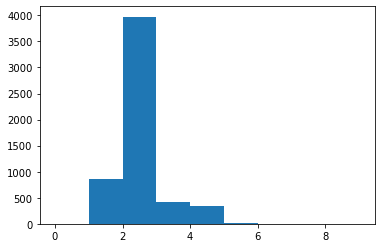

In [17]:
plt.hist(list(node_degrees.values()), bins=range(10))

Most have degree 2, some have 3 and very few have 1 and 4. Looks plausible.

### How many Uber nodes and ways can we match with historic OSM?

In [18]:
unodes = set(uedges_df["osm_start_node_id"]).union(uedges_df["osm_end_node_id"])
uways = set(uedges_df["osm_way_id"])
onodes= set(df_nodes_osm["osmid"])
oways=set(df_ways_osm["osmid"])

In [19]:
uo_nodes = unodes.intersection(onodes)

In [20]:
len(uo_nodes)/len(unodes), len(unodes)-len(uo_nodes), len(uo_nodes), len(unodes)

(0.9971433672558472, 16, 5585, 5601)

In [21]:
uo_ways = uways.intersection(oways)

In [22]:
len(uo_ways)/len(uways), len(uways)-len(uo_ways), len(uo_ways), len(uways)

(0.9960762331838565, 14, 3554, 3568)

### extract geometry for Uber road (create road_graph_nodes.parquet and road_graph_edges.parquet) for Uber road graph

In [23]:
ambiguous = []
projected_geometries = []
status = []
for x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw,refs,osm_start_node_id,osm_end_node_id in zip(uedges_df["x_start_node"],uedges_df["y_start_node"],uedges_df["x_end_node"],uedges_df["y_end_node"],uedges_df["geometry_old"], uedges_df["osm_way_id"], uedges_df["highway"],uedges_df["refs"], uedges_df["osm_start_node_id"], uedges_df["osm_end_node_id"]):
#     print(x_start_node,y_start_node,x_end_node,y_end_node)
#     print(osm_way_id)
#     print(hw)
    
    # 
    if geometry is None:

        if hw is None:
            assert osm_way_id in uways
            assert osm_way_id not in oways
            status.append("no highway")
        else:
            status.append("no geometry")
        projected_geometries.append(None)
        continue
    coords = list(geometry.coords)
#     print(list(geometry.coords))    
#     assert len(set(geometry.coords))==len(list(geometry.coords)), (osm_way_id,len(set(geometry.coords)),len(list(geometry.coords)))
    
#     start_node_index = [i for i, coord in enumerate(coords) if coord==(x_start_node,y_start_node)]
    start_node_index = [i for i, ref in enumerate(refs) if ref ==osm_start_node_id ]
    if len(start_node_index) != 1:
#         print(x_start_node,y_start_node,x_end_node,y_end_node)
#         print(osm_start_node_id)
#         print(osm_end_node_id)
#         print(osm_way_id)
#         print(refs)
#         raise
        ambiguous.append(osm_way_id)
        projected_geometries.append(None)
        status.append("start node ambiguous")
#         print(x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw)
        continue
    start_node_index=start_node_index[0]
#     print(start_node_index)
    
#     end_node_index = [i for i, coord in enumerate(coords) if coord==(x_end_node,y_end_node)]
    end_node_index = [i for i, ref in enumerate(refs) if ref ==osm_end_node_id]
    
    if len(end_node_index) != 1:
        ambiguous.append(osm_way_id)
        projected_geometries.append(None)
        status.append("end node ambiguous")
#         print(x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw)
        continue
    end_node_index=end_node_index[0]
#     print(end_node_index)
    assert (start_node_index < end_node_index) or  (start_node_index > end_node_index) , (start_node_index ,end_node_index)
#     geometry = LineString(coords[start_node_index:end_node_index+1])
#     print(coords)
#     print(coords[4:2])
# #     break
#     break

    if start_node_index < end_node_index:
        projected_geometries.append(LineString(coords[start_node_index:end_node_index+1]))
    elif start_node_index > end_node_index:
        projected_geometries.append(LineString(reversed(coords[end_node_index:start_node_index+1])))
    else:
        raise
    status.append("ok")
    if len(projected_geometries[-1].coords)==0:
        print(start_node_index,end_node_index)
        print((x_start_node,y_start_node,x_end_node,y_end_node,geometry,osm_way_id,hw,refs,osm_start_node_id,osm_end_node_id))
        raise
uedges_df["geometry"] = projected_geometries
uedges_df["status"]=status        

In [24]:
# TODO visual inspection!
# TODO can improve on the ambiguous?
matching_stats_df = uedges_df.groupby(["highway","status"]).agg(count=("osmid","count"), avg_length_meters=("length_meters", "mean"))
matching_stats_df["percentage"] = matching_stats_df["count"]/len(uedges_df)*100
matching_stats_df = matching_stats_df.reset_index()
matching_stats_df

,highway,status,count,avg_length_meters,percentage
0,living_street,end node ambiguous,1,18.589621,0.016485
1,living_street,ok,24,68.646235,0.395648
2,motorway,ok,16,225.766332,0.263765
3,motorway_link,ok,3,202.830347,0.049456
4,primary,end node ambiguous,7,58.795670,0.115397
5,primary,ok,709,83.534679,11.688098
6,primary,start node ambiguous,9,119.374287,0.148368
7,primary_link,end node ambiguous,2,83.773630,0.032971
8,primary_link,ok,216,71.612674,3.560831
9,primary_link,start node ambiguous,1,36.665022,0.016485


In [25]:
len(~uedges_df["geometry"].isnull())

6066

In [26]:
uedges_df[uedges_df["geometry"].isnull()].groupby("highway").agg(count=("osmid","count"), avg_length_meters=("length_meters", "mean"), med_length_meters=("length_meters", "median"), status=("status", set))

,count,avg_length_meters,med_length_meters,status
highway,,,,
living_street,1,18.589621,18.589621,{end node ambiguous}
primary,16,92.450457,48.167963,"{end node ambiguous, start node ambiguous}"
primary_link,3,68.070761,36.665022,"{end node ambiguous, start node ambiguous}"
residential,22,54.449741,29.797807,"{end node ambiguous, start node ambiguous}"
secondary,30,80.277457,31.494996,"{end node ambiguous, start node ambiguous}"
secondary_link,1,20.660408,20.660408,{start node ambiguous}
tertiary,23,36.628722,19.813411,"{end node ambiguous, start node ambiguous}"
tertiary_link,2,76.442226,76.442226,"{end node ambiguous, start node ambiguous}"
trunk,4,NaN,NaN,"{end node ambiguous, start node ambiguous}"


In [27]:
uedges_df[(uedges_df["geometry"].isnull())&(uedges_df["highway"]=="motorway")]

# refs [311070, 3744469281] 
# https://www.openstreetmap.org/way/345803322#map=17/51.25284/-0.12408
# https://www.openstreetmap.org/node/202995#map=16/51.2518/-0.1270       -> probably just deleted between recording and OSM version
# https://www.openstreetmap.org/node/3744469281#map=19/51.25548/-0.12439 -> in OSM
# here we could fix if the missing one has just one outgoing edge.


,osmid,version,timestamp,changeset,highway,maxspeed,name,refs,full_geometry,valid_geometry,geometry,osm_start_node_id,osm_end_node_id,osm_way_id,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_start_node,y_start_node,x_start_node,version_start_node,timestamp_start_node,changeset_start_node,geometry_start_node,osmid_end_node,y_end_node,x_end_node,version_end_node,timestamp_end_node,changeset_end_node,geometry_end_node,length_meters,geometry_old,status


In [28]:
uedges_debug_gdf = gpd.GeoDataFrame.from_records([{"name":name, "geometry": LineString(geometry.coords)} for name,geometry,status in zip(uedges_df["name"],uedges_df["geometry_old"],uedges_df["status"]) if geometry is not None and "ambiguous" in status])
uedges_debug_gdf

,name,geometry
0,Carrer de la Riera Alta,"LINESTRING (2.16310 41.38038, 2.16318 41.38036..."
1,Carrer de la Riera Blanca,"LINESTRING (2.12492 41.37321, 2.12508 41.37312..."
2,Carrer de Mas,"LINESTRING (2.12387 41.37420, 2.12385 41.37419)"
3,Carrer de Mas,"LINESTRING (2.12387 41.37420, 2.12385 41.37419)"
4,Carrer de Mas,"LINESTRING (2.12387 41.37420, 2.12385 41.37419)"
...,...,...
99,Ronda Litoral,"LINESTRING (2.20759 41.44116, 2.20769 41.44094..."
100,Carrer de Laureà Miró,"LINESTRING (2.04630 41.37968, 2.04642 41.37963..."
101,Passeig de Llorenç Serra,"LINESTRING (2.20301 41.44961, 2.20302 41.44960)"
102,Passeig de Llorenç Serra,"LINESTRING (2.20301 41.44961, 2.20302 41.44960)"


In [29]:
uedges_debug_gdf.to_parquet(f"{CITY}_road_graph_edges_debug.parquet")

In [30]:
uedges_debug_gdf.to_file(f"{CITY}_road_graph_edges_debug.gpkg", driver="GPKG", layer="edges")

## Add speed_kph

In [31]:
edges = uedges_df

# Logic taken from
# https://github.com/gboeing/osmnx/blob/ad54852a3131800b1eedeb167eccaa0276abd998/osmnx/speed.py

from osmnx.speed import _collapse_multiple_maxspeed_values, _clean_maxspeed


hwy_speeds=None
fallback=np.nan
precision=1
agg=np.mean

# collapse any highway lists (can happen during graph simplification)
# into string values simply by keeping just the first element of the list
edges["highway"] = edges["highway"].map(lambda x: x[0] if isinstance(x, list) else x)

if "maxspeed" in edges.columns:
    # collapse any maxspeed lists (can happen during graph simplification)
    # into a single value
    edges["maxspeed"] = edges["maxspeed"].apply(_collapse_multiple_maxspeed_values, agg=agg)

    # create speed_kph by cleaning maxspeed strings and converting mph to
    # kph if necessary
    edges["speed_kph"] = edges["maxspeed"].astype(str).map(_clean_maxspeed).astype(float)
else:
    # if no edges in graph had a maxspeed attribute
    edges["speed_kph"] = None

# if user provided hwy_speeds, use them as default values, otherwise
# initialize an empty series to populate with values
if hwy_speeds is None:
    hwy_speed_avg = pd.Series(dtype=float)
else:
    hwy_speed_avg = pd.Series(hwy_speeds).dropna()

# for each highway type that caller did not provide in hwy_speeds, impute
# speed of type by taking the mean of the preexisting speed values of that
# highway type
for hwy, group in edges.groupby("highway"):
    if hwy not in hwy_speed_avg:
        hwy_speed_avg.loc[hwy] = agg(group["speed_kph"])

# if any highway types had no preexisting speed values, impute their speed
# with fallback value provided by caller. if fallback=np.nan, impute speed
# as the mean speed of all highway types that did have preexisting values
hwy_speed_avg = hwy_speed_avg.fillna(fallback).fillna(agg(hwy_speed_avg))

# for each edge missing speed data, assign it the imputed value for its
# highway type
speed_kph = (
    edges[["highway", "speed_kph"]].set_index("highway").iloc[:, 0].fillna(hwy_speed_avg)
)

# all speeds will be null if edges had no preexisting maxspeed data and
# caller did not pass in hwy_speeds or fallback arguments
if pd.isnull(speed_kph).all():
    raise ValueError(
        (
            "this graph's edges have no preexisting `maxspeed` "
            "attribute values so you must pass `hwy_speeds` or "
            "`fallback` arguments."
        )
    )

# add speed kph attribute to graph edges
edges["speed_kph"] = speed_kph.round(precision).values

## Output road_graph_nodes.parquet and road_graph_edges.parquet in compliant format

In [32]:
# edges_attributes_list = ["u", "v", "osmid", "speed_kph", "maxspeed", "highway", "oneway", "lanes", "tunnel", "length_meters", "geometry"]
# [["node_id", "x", "y"]]

In [33]:
for u,v,osmid,highway,length_meters,geometry,status in zip(
        uedges_df["osm_start_node_id"],
        uedges_df["osm_end_node_id"],
        uedges_df["osm_way_id"],
        uedges_df["highway"],
        uedges_df["length_meters"],
        uedges_df["geometry"],
        uedges_df["status"]
    ):
    if status=="ok" and len(geometry.coords)==0:
        print((u,v,osmid,highway,length_meters,geometry,status))
        break

In [34]:
uedges_gdf = gpd.GeoDataFrame.from_records([{
    "gkey": f"{u}_{v}_{osmid}", # TODO hacky
    "u":u, 
    "v":v, 
    "osmid":osmid, 
    "speed_kph": speed_kph, 
    "maxspeed": maxspeed, 
    "highway":highway, 
    "oneway":"", # TODO
    "lanes":"", # TODO
    "tunnel":"", # TODO
    "length_meters":length_meters, 
    "geometry": LineString(geometry.coords),
    "name": name # TODO in addition to data_pipeline - add there as well?
} 
    for u,v,osmid,speed_kph,maxspeed,highway,length_meters,geometry,status,name in zip(
        uedges_df["osm_start_node_id"],
        uedges_df["osm_end_node_id"],
        uedges_df["osm_way_id"],
        uedges_df["speed_kph"],
        uedges_df["maxspeed"],
        uedges_df["highway"],
        uedges_df["length_meters"],
        uedges_df["geometry"],
        uedges_df["status"],
        uedges_df["name"],
    ) if status=="ok"])
uedges_gdf

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,21638861_21638859_291731095,21638861,21638859,291731095,50.0,50,residential,,,,198.710412,"LINESTRING (2.18804 41.37801, 2.18821 41.37757...",Passeig de Joan de Borbó
1,21638872_4229056910_291731094,21638872,4229056910,291731094,50.0,50,tertiary,,,,83.740778,"LINESTRING (2.18774 41.37880, 2.18801 41.37809)",Passeig de Joan de Borbó
2,21638874_21638872_291731094,21638874,21638872,291731094,50.0,50,tertiary,,,,187.993767,"LINESTRING (2.18712 41.38037, 2.18715 41.38029...",Passeig de Joan de Borbó
3,21638886_2952200683_237790232,21638886,2952200683,237790232,50.0,50,tertiary,,,,80.120100,"LINESTRING (2.18596 41.38128, 2.18638 41.38108...",Passeig de Joan de Borbó
4,21638891_533663031_18512190,21638891,533663031,18512190,50.0,50,tertiary,,,,177.556771,"LINESTRING (2.18319 41.38260, 2.18313 41.38252...",Passeig d'Isabel II
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,6485217417_380722287_576957404,6485217417,380722287,576957404,50.0,50,tertiary,,,,60.841548,"LINESTRING (2.18607 41.50057, 2.18633 41.50105)",Carretera de Barcelona a Puigcerdá
5939,6485217427_425763064_36005986,6485217427,425763064,36005986,50.0,50,tertiary,,,,31.372892,"LINESTRING (2.18590 41.50021, 2.18602 41.50047)",Carrer Pla de Matabous
5940,6486942738_434451638_37286986,6486942738,434451638,37286986,50.0,50,tertiary,,,,430.706510,"LINESTRING (2.20816 41.43474, 2.20860 41.43526...",pont del Molinet
5941,6487028700_412453967_662919197,6487028700,412453967,662919197,50.0,50,secondary,,,,177.087661,"LINESTRING (2.14297 41.41323, 2.14297 41.41324...",Avinguda de Vallcarca


In [35]:
uedges_gdf.dtypes

gkey               object
u                   int64
v                   int64
osmid              object
speed_kph         float64
maxspeed           object
highway            object
oneway             object
lanes              object
tunnel             object
length_meters     float64
geometry         geometry
name               object
dtype: object

In [36]:
assert type(uedges_gdf) == gpd.geodataframe.GeoDataFrame

In [37]:
# TODO naming as "london/road_graph_edges.parquet"
uedges_gdf.to_parquet(f"{CITY}_road_graph_edges.parquet")

In [38]:
uedges_gdf.to_file(f"{CITY}_road_graph_edges.gpkg", driver="GPKG", layer="edges")

In [39]:
nodes_in_uedges_gdf = set(uedges_gdf["u"]).union(uedges_gdf["v"])
nodes_in_uedges_gdf

{1134264320,
 412549129,
 412549130,
 2917908492,
 387612689,
 412549137,
 302219283,
 412549138,
 412549139,
 478855185,
 302219282,
 251543584,
 494092349,
 1446461501,
 216350784,
 4635066443,
 2707390543,
 30343257,
 1567162458,
 3984932958,
 6131466345,
 30556269,
 126697585,
 1567162482,
 1567162485,
 478855288,
 516243578,
 4587765894,
 434487433,
 516243593,
 4587765898,
 4587765901,
 3439181965,
 516243600,
 1567162518,
 516243606,
 30294177,
 30294184,
 2114994356,
 30294197,
 1375092918,
 412451004,
 412451006,
 412451010,
 557187269,
 412451014,
 412451016,
 478855374,
 104431832,
 528056538,
 302219487,
 557187296,
 3713384673,
 269385954,
 528056546,
 421265639,
 1375092972,
 942080240,
 5241929970,
 30343411,
 30556408,
 30556410,
 30556411,
 30556413,
 30556414,
 1375092989,
 30556416,
 942080260,
 4438982923,
 942080268,
 4554375436,
 4554375438,
 968278291,
 5649907994,
 942080284,
 942080285,
 323191074,
 323191075,
 253788453,
 323191078,
 942080295,
 559415593,
 55

In [40]:
unodes_gdf = gpd.GeoDataFrame.from_records([{
    "node_id":node_id, 
    "x":x, 
    "y":y,
    "geometry": geometry} 
    for node_id,x,y,geometry in zip(
        df_nodes_osm["osmid"],
        df_nodes_osm["x"],
        df_nodes_osm["y"],
        df_nodes_osm["geometry"]
    )
    if node_id in nodes_in_uedges_gdf
])
unodes_gdf

,node_id,x,y,geometry
0,21638859,2.188693,41.376347,POINT (2.18869 41.37635)
1,21638861,2.188040,41.378011,POINT (2.18804 41.37801)
2,21638872,2.187738,41.378797,POINT (2.18774 41.37880)
3,21638874,2.187119,41.380371,POINT (2.18712 41.38037)
4,21638886,2.185963,41.381278,POINT (2.18596 41.38128)
...,...,...,...,...
5525,6485217427,2.185904,41.500209,POINT (2.18590 41.50021)
5526,6485528262,2.030090,41.335952,POINT (2.03009 41.33595)
5527,6486942738,2.208156,41.434742,POINT (2.20816 41.43474)
5528,6487028700,2.142968,41.413227,POINT (2.14297 41.41323)


In [41]:
unodes_gdf.to_parquet(f"{CITY}_road_graph_nodes.parquet")

In [42]:
unodes_gdf.to_file(f"{CITY}_road_graph_nodes.gpkg", driver="GPKG", layer="nodes")

In [43]:
assert len(uedges_gdf) == matching_stats_df[matching_stats_df["status"]=="ok"]["count"].sum()